# Social Network Analysis of BEA Industries

- Input-Output Use Tables, Social Relations Regression Model
- igraph, rpy2, Bureau of Economic Analysis

Terence Lim

In [1]:
import os
import time
import numpy as np
import numpy.ma as ma
from numpy.ma import masked_invalid as valid
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import igraph  # pip3 install cairocffi
from igraph import Graph
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR
from finds.busday import BusDay
from finds.database import SQL, Redis
from finds.structured import CRSP, PSTAT
from finds.sectors import Sectoring, BEA
from finds.graph import igraph_draw
from settings import settings
ECHO = False
sql = SQL(**settings['sql'])
bd = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bd, rdb)
pstat = PSTAT(sql, bd)
bea = BEA(rdb, **settings['bea'], echo=ECHO)
logdir = os.path.join(settings['images'], 'bea')
years = np.arange(1947, 2020) 
vintages = [1997, 1963, 1947]   # when sectoring schemes were revised

## Read IOUse tables from BEA website

In [2]:
ioUses = dict()
for vintage in vintages:
    for year in [y for y in years if y >= vintage]:
        df = bea.read_ioUse(year, vintage=vintage)
        ioUses[(vintage, year)] = df
    print(f"{len(ioUses)} tables through sectoring vintage year {vintage}")

23 tables through sectoring vintage year 1997
80 tables through sectoring vintage year 1963
153 tables through sectoring vintage year 1947


## Smooth average flows over several years, for social relations regression

In [3]:
tgt = 'colcode'   # head of edge is user industry (table column)
src = 'rowcode'   # tail of edge is maker industry (table row)
drop = ('F','T','U','V','Other')  # drop these codes
vintage = 1997    # latest sectoring scheme vintage year

# Total up production of all src->tgt; normalize; as edges in DiGraph
total = DataFrame()
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    # keep year, drop invalid rows
    ioUse = ioUses[(vintage, year)]
    data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
                  ~ioUse['colcode'].str.startswith(drop))].copy()
    data = data[(data['colcode'] != data['rowcode'])]
    data['year'] = year
    total = total.append(data[['year', 'rowcode', 'colcode', 'datavalue']])

## Populate and visualize directed graph

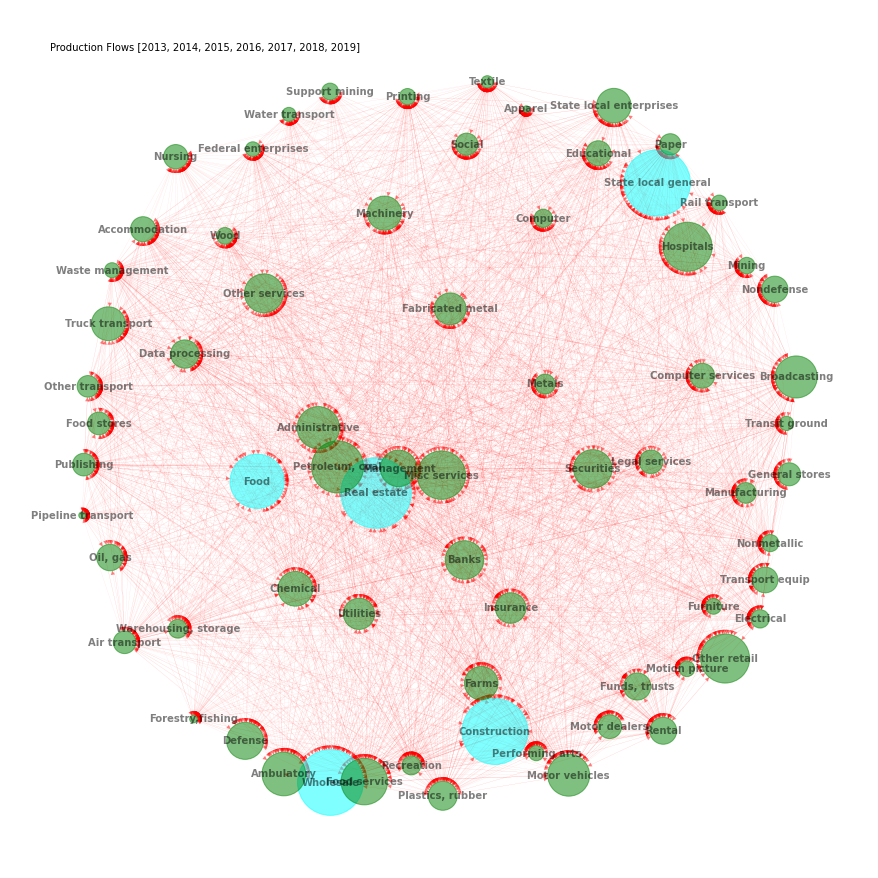

In [4]:
d = total.groupby(['rowcode', 'colcode'])['datavalue'].sum().reset_index()
d['weights'] = d['datavalue'] / d['datavalue'].sum()
edges = d.loc[d['weights'] > 0, [src, tgt, 'weights', 'datavalue']].values
g = Graph.TupleList(edges, edge_attrs=['weight','value'], directed=True)
g.vs['bea'] = list(BEA.bea_industry[g.vs['name']])

# visualize graph
score = g.strength(weights='weight', mode='in')
node_size = pd.Series(data=score, index=g.vs['name']).to_dict()
node_color = {k: 'green' for k in g.vs["name"]}
center_name = g.vs['name'][np.argmax(score)]
top_color = g.vs[list(np.argsort(score)[-5:])]["name"]
node_color.update({k: 'cyan' for k in top_color})
pos = igraph_draw(
    g, num=1, center_name=center_name,
    node_color=node_color, node_size=node_size, edge_color='r', k=2,
    pos=None, font_size=10, figsize=(12,12),
    labels={k:v for k,v in zip(g.vs['name'], g.vs['bea'])},
    title=f"Production Flows {list(total['year'].unique())}")
plt.show()

## Construct monthly BEAT industry returns for the same period of years

In [5]:
codes = Sectoring(sql, f"bea{vintage}", fillna='')
naics = pstat.build_lookup('lpermno', 'naics', fillna=0)
caps, counts, rets = [], [], []
for year in years:
    date = bd.endyr(year - 1)
    univ = crsp.get_universe(date)
    univ['bea'] = codes[naics(univ.index, date)]
    univ = univ[univ['bea'].ne('')]
    grouped = univ.groupby('bea')
    caps.append(grouped['cap'].sum().rename(year))
    counts.append(grouped['cap'].count().rename(year))
        
    months = bd.date_range(date, bd.endyr(year), 'endmo')
    for rebaldate, end in zip(months[:-1], months[1:]):
        r = pd.concat([crsp.get_ret(bd.begmo(end), end),
                       crsp.get_cap(rebaldate, use_permco=False),
                       univ['bea']], axis=1, join='inner').dropna()
        grp = r.groupby('bea')   # industry ret is sum of weighted rets
        r['wtdret'] = r['ret'].mul(r['cap'].div(grp['cap'].transform('sum')))
        rets.append(grp['wtdret'].sum(min_count=1).rename(end))
        #print(end, len(r), r['wtdret'].sum() / len(grp))

## Collect and average market caps, counts and returns

In [6]:
caps = pd.concat(caps, axis=1).mean(axis=1)     # average cap over years
counts = pd.concat(counts, axis=1).mean(axis=1) # average count
rets = pd.concat(rets, axis=1)
rets

,20130131,20130228,20130328,20130430,20130531,20130628,20130731,20130830,20130930,20131031,...,20190329,20190430,20190531,20190628,20190731,20190830,20190930,20191031,20191129,20191231
bea,,,,,,,,,,,,,,,,,,,,,
111CA,0.027914,-0.034061,0.039591,-0.007433,0.015147,0.085596,0.081020,-0.029609,0.035032,0.013429,...,-0.008738,-0.047867,-0.098133,0.096741,-0.004872,-0.023071,0.002279,-0.009605,0.067719,-0.014566
211,0.074160,-0.004657,0.048952,-0.050738,0.035059,0.006693,0.075046,0.002901,0.113080,0.071022,...,0.045793,0.024595,-0.166769,0.091401,-0.101411,-0.106835,0.036799,-0.047517,0.005490,0.142370
212,0.003827,-0.077273,0.008441,-0.097420,0.002605,-0.104051,0.008807,0.042952,0.016260,0.061390,...,0.049412,-0.010382,-0.076595,0.143847,-0.030728,-0.030115,0.028277,0.004717,0.031855,0.097442
213,0.142155,0.013891,-0.005563,0.002656,0.001391,-0.001038,0.051718,0.012744,0.026035,0.099658,...,0.000383,-0.044724,-0.203570,0.084908,-0.022944,-0.195457,0.031848,-0.045790,0.058433,0.175677
22,0.062559,0.023372,0.058383,0.040715,-0.041997,0.013072,0.076498,-0.057581,0.033850,0.043655,...,0.045137,-0.000649,-0.019209,0.041982,0.008862,0.027015,0.017939,-0.028034,-0.032287,0.044647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711AS,0.034754,0.040442,0.137419,0.014468,0.062312,0.057929,0.062030,-0.002250,0.076083,0.038061,...,0.084024,0.059712,-0.052457,0.030929,0.062262,-0.024080,-0.014914,0.039843,0.021425,0.026550
713,0.028135,-0.001098,0.064411,0.044420,0.033108,-0.037669,0.068097,-0.000639,0.028043,0.015519,...,-0.014763,0.076284,-0.026825,0.012171,0.057403,-0.030572,-0.066363,0.033488,0.081837,0.042113
721,0.131084,-0.040550,0.081772,0.022882,0.021581,-0.062075,0.054184,0.014468,0.123164,0.044890,...,-0.009918,0.089053,-0.111946,0.117252,0.011433,-0.077233,0.013140,0.049612,0.067226,0.082228


## Create node variables: count and cap (will take logs of)

In [7]:
nodevars = pd.concat([caps.rename('cap'), counts.rename('count')], axis=1)
rets = rets.T[nodevars.index]    # ensure same order of industries
n = len(nodevars.index)
nodevars.index = BEA.bea_industry[nodevars.index]
nodevars

,cap,count
Farms,3.232116e+06,5.571429
"Oil, gas",1.017731e+08,60.285714
Mining,1.081295e+08,29.714286
Support mining,8.940056e+07,23.571429
Utilities,1.293549e+08,39.142857
...,...,...
Performing arts,1.860748e+07,8.571429
Recreation,2.506987e+07,22.571429
Accommodation,1.406575e+08,17.857143
Food services,2.979590e+08,53.000000


## Create dyadic variables: correlations of monthly, lead and lagged returns

In [8]:
corrs = rets.join(rets.shift(), rsuffix='r').corr().to_numpy()
corr = corrs[:n, :n]   # corr is top-left block
lead = corrs[:n, n:]   # lead is top-right block
lag = corrs[n:, :n]    # lag is bottom-left block
np.fill_diagonal(corr, np.nan)   # drop own-correlations
np.fill_diagonal(lead, np.nan)
np.fill_diagonal(lag, np.nan)
dyadvars = np.stack((corr, lead, lag), axis=-1)
dyadvars

array([[[        nan,         nan,         nan],
        [ 0.32365155,  0.01068469,  0.00535182],
        [ 0.12686202,  0.04410639, -0.00357508],
        ...,
        [ 0.18584099, -0.01117636, -0.08943949],
        [ 0.3465652 , -0.10768129, -0.16481324],
        [ 0.40343104, -0.11474959, -0.21470003]],

       [[ 0.32365155,  0.00535182,  0.01068469],
        [        nan,         nan,         nan],
        [ 0.63158961,  0.06776828, -0.0327963 ],
        ...,
        [ 0.49083167,  0.01764319, -0.12311876],
        [ 0.17600642, -0.17774694, -0.14983005],
        [ 0.4262596 , -0.15982674, -0.11964364]],

       [[ 0.12686202, -0.00357508,  0.04410639],
        [ 0.63158961, -0.0327963 ,  0.06776828],
        [        nan,         nan,         nan],
        ...,
        [ 0.54552254, -0.07775837, -0.07986927],
        [ 0.11227052, -0.16065737, -0.12963952],
        [ 0.40480004, -0.24429861, -0.03183499]],

       ...,

       [[ 0.18584099, -0.08943949, -0.01117636],
        [ 0

## Social Network Analysis using R and $Amen$ package
- see Hoff (2018)

In [9]:
# By convention: R objects to have '_ro' suffix
stats_ro    = importr('stats')
base_ro     = importr('base')
matrix_ro   = ro.r['matrix']
t_ro        = ro.r['t']
anova_ro    = ro.r['anova']
lm_ro       = ro.r['lm']
summary_ro  = ro.r['summary']
plot_ro     = ro.r['plot']
    
amen_ro     = importr('amen')
ame_ro      = ro.r['ame']  # default nscan=10000, odens=25 => 400 samples
circplot_ro = ro.r['circplot']

## Assemble flow edges

In [10]:
Y = PyR(g.get_adjacency('value').data, names=[list(g.vs['bea'])]*2)
Y = Y[nodevars.index, nodevars.index]
Y.assign(np.log(Y.values + 1))    # take logs of flow edges
Y[:5,:5]  # looks reasonable?

                    Farms   Oil, gas     Mining  Support mining  Utilities
Farms            0.000000   0.000000   6.232448        5.638355   0.000000
Oil, gas         0.000000   0.000000   2.639057        0.693147  12.435485
Mining           9.799349   6.715383   0.000000        6.343880  11.548215
Support mining   0.000000  11.168151   9.419304        0.000000   0.000000
Utilities       10.392987  10.536194  10.074116        6.963190   0.000000

## Run ANOVA

In [11]:
rowsector_ro = matrix_ro(Y.rownames, Y.nrow, Y.ncol)
colsector_ro = t_ro(rowsector_ro)
formula_ro = ro.Formula("c(Y) ~ c(Rowsector) + c(Colsector)")
formula_ro.environment['Rowsector'] = rowsector_ro
formula_ro.environment['Colsector'] = colsector_ro
formula_ro.environment['Y'] = Y.ro
results_ro = anova_ro(lm_ro(formula_ro))
print(results_ro)
PyR(results_ro).frame

Analysis of Variance Table

Response: c(Y)
               Df Sum Sq Mean Sq F value    Pr(>F)    
c(Rowsector)   61  43720  716.72  127.84 < 2.2e-16 ***
c(Colsector)   61   4193   68.73   12.26 < 2.2e-16 ***
Residuals    3721  20861    5.61                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



,Df,Sum Sq,Mean Sq,F value,Pr(>F)
c(Rowsector),61,43719.717887,716.716687,127.843244,0.000000e+00
c(Colsector),61,4192.735431,68.733368,12.260209,1.063727e-106
Residuals,3721,20860.725274,5.606215,NaN,NaN


In [12]:
print(results_ro)

Analysis of Variance Table

Response: c(Y)
               Df Sum Sq Mean Sq F value    Pr(>F)    
c(Rowsector)   61  43720  716.72  127.84 < 2.2e-16 ***
c(Colsector)   61   4193   68.73   12.26 < 2.2e-16 ***
Residuals    3721  20861    5.61                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



## display user effects

In [13]:
muhat = np.nanmean(Y.ro)
Ahat = PyR(Y.frame.mean(axis=1) - muhat, names='Ahat')
Ahat.frame['Ahat'].sort_values(ascending=False).to_frame()

,Ahat
Misc services,5.095757
Administrative,4.622875
Real estate,4.427939
Banks,3.802007
Rental,3.780523
...,...
Hospitals,-5.594712
Nursing,-5.594712
Social,-5.594712
Food stores,-5.594712


## display maker effects

In [14]:
Bhat = PyR(Y.frame.mean(axis=0) - muhat, names='Bhat')
Bhat.frame['Bhat'].sort_values(ascending=False).to_frame()

,Bhat
Misc services,2.400187
Wholesale,2.262612
Other services,1.974399
Other retail,1.831443
Administrative,1.746204
...,...
Air transport,-1.673922
"Funds, trusts",-2.088300
Pipeline transport,-2.111330
Water transport,-2.308916


## But ignores corr of random effects
- which are fundamental characteristic of dyads


In [15]:
#print(np.cov(Ahat.values, Bhat.values))
print(np.corrcoef(Ahat.values, Bhat.values)[0,1])
outer = Y.values - (muhat + np.add.outer(Ahat.values, Bhat.values))
#print(ma.cov(valid(outer.ravel()), valid(outer.T.ravel()).data)
ma.corrcoef(valid(outer.ravel()), valid(outer.T.ravel()))[0,1]

0.20408991228568846


0.23889361276494767

## Run Social Relations Model (SRM)


Regression coefficients:
          pmean   psd z-stat p-val
intercept 4.506 0.509  8.856     0

Variance parameters:
     pmean   psd
va  12.941 2.600
cab  1.130 0.552
vb   1.120 0.219
rho  0.119 0.022
ve   4.929 0.120


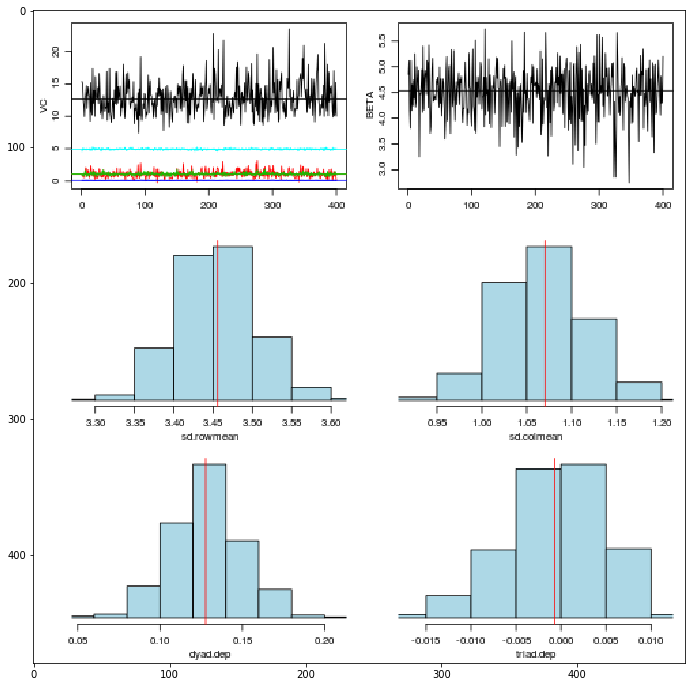

In [16]:
fit_SRM_ro = ame_ro(Y.ro, plot=False, print=False)
Fit_SRM = PyR(fit_SRM_ro)
_ = summary_ro(fit_SRM_ro)
plot_ro(fit_SRM_ro)
if logdir: PyR.savefig(os.path.join(logdir, 'srm.png'))

## Compare empirical and model estimates

In [17]:
print(muhat, np.nanmean(Fit_SRM['BETA'].values))  # overall mean
print(np.cov(Ahat.values, Bhat.values))           # mean covariances
vcmean = Fit_SRM['VC'][:, :4].frame.mean()        # posterior variance parms
print(vcmean[:3])

5.59471218949869 4.506261859973058
[[11.55994656  0.73061304]
 [ 0.73061304  1.10860271]]
va     12.940928
cab     1.129711
vb      1.120451
dtype: float64


## Residual Dyadic Correlation

In [18]:
print(vcmean['cab'] / (np.sqrt(vcmean['va']) * np.sqrt(vcmean['vb'])))
print(ma.corrcoef(valid(outer.ravel()), valid(outer.T.ravel()))[0,1])    
print(np.mean(Fit_SRM['VC'][:, 3].values))

0.29667992078206995
0.23889361276494767
0.11906353656490244


## Run Social Relations Regression Model (SSRM)


Regression coefficients:
           pmean   psd z-stat p-val
intercept  6.203 5.659  1.096 0.273
cap.row   -0.406 0.377 -1.076 0.282
count.row  1.294 0.558  2.318 0.020
cap.col   -0.021 0.127 -0.165 0.869
count.col  0.159 0.191  0.830 0.406
corr.dyad  4.086 0.430  9.493 0.000
lead.dyad  0.344 0.635  0.542 0.588
lag.dyad   0.657 0.634  1.036 0.300

Variance parameters:
    pmean   psd
va  9.862 1.909
cab 0.122 0.442
vb  1.011 0.217
rho 0.093 0.023
ve  4.801 0.118


,sd.rowmean,sd.colmean,dyad.dep,triad.dep
obs,3.455730,1.070163,0.127804,-0.000721
mean,3.456230,1.077039,0.128050,0.002765
std,0.052233,0.050374,0.023218,0.005241


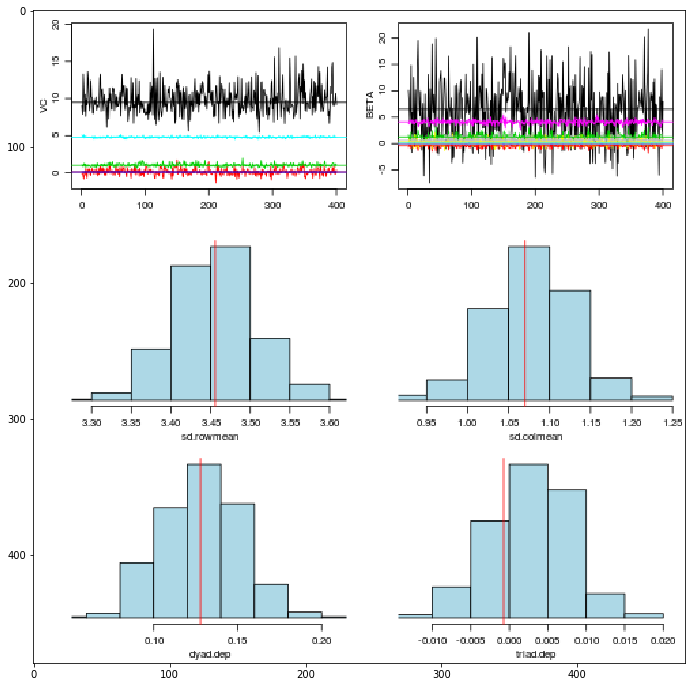

In [19]:
Xn = PyR(np.log(nodevars))  # nodevars are logs of caps and counts
Xd = PyR(dyadvars, names=[nodevars.index]*2 + [['corr', 'lead', 'lag']])
fit_srrm_ro = ame_ro(Y.ro, Xd=Xd.ro, Xr=Xn.ro, Xc=Xn.ro,
                     plot=False, print=False)
Fit_srrm = PyR(fit_srrm_ro)
_ = summary_ro(fit_srrm_ro)
plot_ro(fit_srrm_ro)
if logdir: PyR.savefig(os.path.join(logdir, 'ssrm.png'))
gof = Fit_srrm['GOF'].frame.iloc[:1,:]  # actual in first row of gof
gof.loc['mean', :] = np.nanmean(Fit_srrm['GOF'].values[1:, :], axis=0)
gof.loc['std', :] = np.nanstd(Fit_srrm['GOF'].values[1:, :], axis=0)
gof

## Run OLS Model


Regression coefficients:
            pmean   psd  z-stat p-val
intercept   6.674 1.212   5.505 0.000
cap.row    -0.526 0.059  -8.848 0.000
count.row   1.573 0.091  17.337 0.000
cap.col     0.064 0.058   1.118 0.263
count.col  -0.083 0.091  -0.912 0.362
corr.dyad   2.480 0.423   5.863 0.000
lead.dyad -10.015 0.649 -15.432 0.000
lag.dyad   -1.673 0.708  -2.362 0.018

Variance parameters:
     pmean   psd
va   0.000 0.000
cab  0.000 0.000
vb   0.000 0.000
rho  0.000 0.000
ve  13.484 0.301


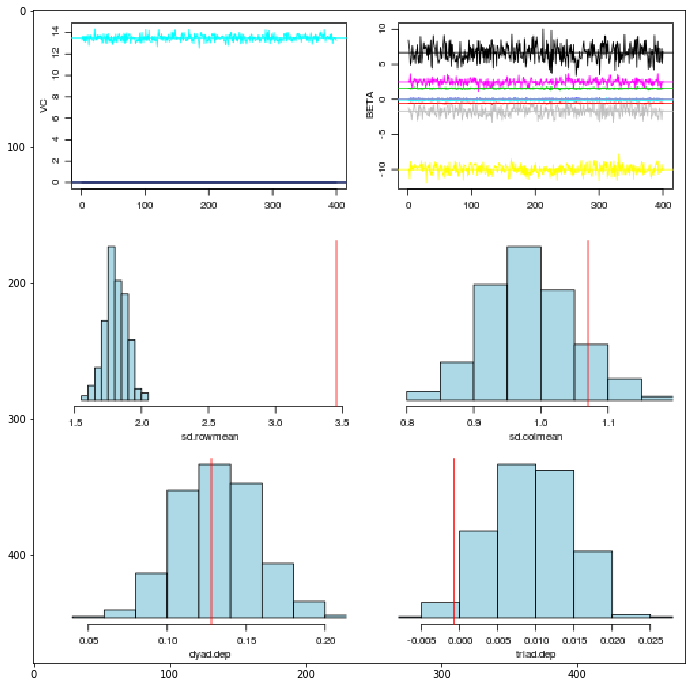

In [20]:
fit_rm_ro = ame_ro(Y.ro, Xd=Xd.ro, Xr=Xn.ro, Xc=Xn.ro, print=False,
                   plot=False, rvar=False, cvar=False, dcor=False)
summary_ro(fit_rm_ro)
plot_ro(fit_rm_ro)
if logdir: PyR.savefig(os.path.join(logdir, 'ols.png'))

## Run SRRM with latent multiplicative effects


Regression coefficients:
           pmean   psd z-stat p-val
intercept  6.602 5.862  1.126 0.260
cap.row   -0.385 0.390 -0.988 0.323
count.row  1.333 0.576  2.314 0.021
cap.col   -0.066 0.110 -0.599 0.549
count.col  0.300 0.166  1.807 0.071
corr.dyad  2.784 0.396  7.036 0.000
lead.dyad  0.258 0.534  0.484 0.629
lag.dyad   0.562 0.541  1.039 0.299

Variance parameters:
     pmean   psd
va  10.146 1.873
cab  0.298 0.386
vb   0.632 0.172
rho  0.039 0.025
ve   3.508 0.088


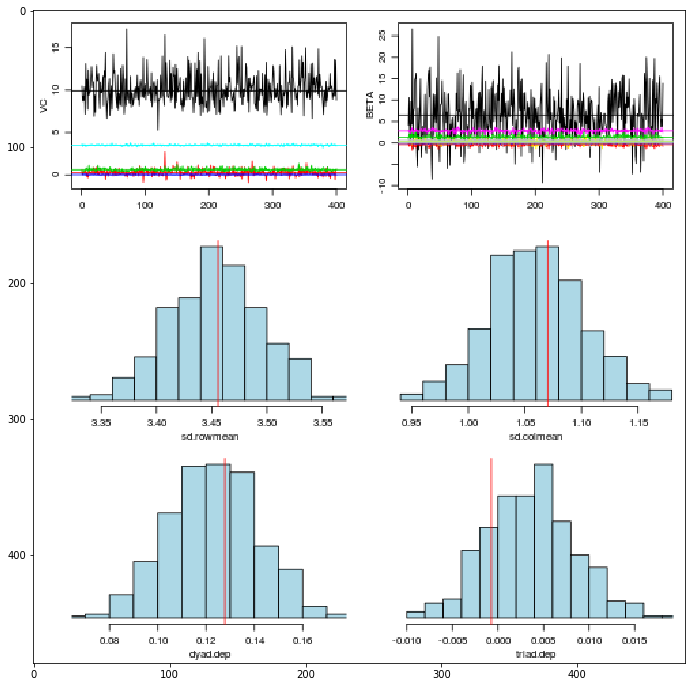

In [21]:
fit_ame2_ro = ame_ro(Y.ro, Xd=Xd.ro, Xr=Xn.ro, Xc=Xn.ro, R=2,
                     plot=False, print=False)
Fit_ame2 = PyR(fit_ame2_ro)
summary_ro(fit_ame2_ro)
plot_ro(fit_ame2_ro)
if logdir: PyR.savefig(os.path.join(logdir, 'multiplicative.png'))

## Circular plots of multiplicative factor SRRM

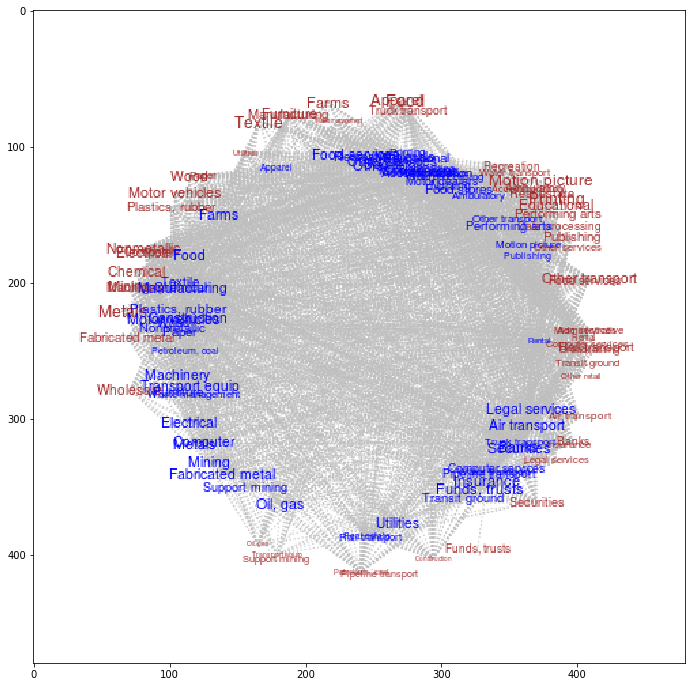

In [23]:
logdir = os.path.join(settings['images'], 'bea')
circplot_ro(Y.ro, U=fit_ame2_ro.rx2['U'], V=fit_ame2_ro.rx2['V'],
            row_names=Y.rownames, col_names=Y.colnames,
            plotnames=True, pscale=0.75)
if logdir: PyR.savefig(os.path.join(logdir, 'circ.png'))
